### Make star shape dataset

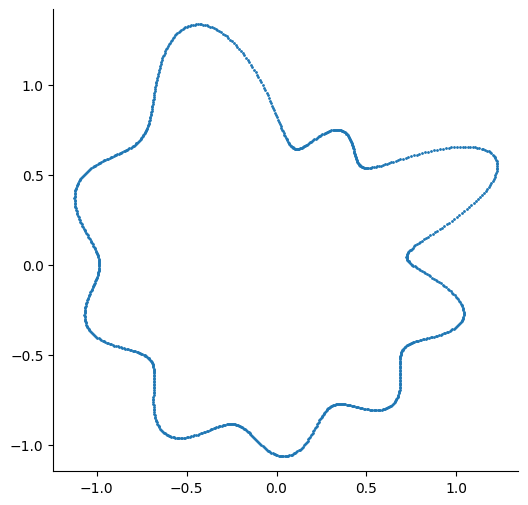

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def create_star_shape_data(num_points, num_modes):
    angles = np.linspace(0, 2*np.pi, num_points)
    radii = np.ones(num_points)
    
    for mode in range(1, num_modes+1):
        amplitude = 0.2 * np.random.rand() - 0.1
        phase = np.random.rand() * 2 * np.pi
        radii += amplitude * np.cos(mode * angles + phase)
    
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    pnts = np.vstack((x, y)).T
    return pnts

num_points = 1000
num_modes = 10
pnts = create_star_shape_data(num_points, num_modes)
plt.figure(figsize=(6, 6))
plt.scatter(pnts[:, 0], pnts[:, 1], s=1)
plt.axis('equal')
plt.show()

In [ ]:

def create_star_shape_data(num_points, num_modes):
    angles = np.linspace(0, 2*np.pi, num_points)
    radii = np.ones(num_points)
    
    for mode in range(1, num_modes+1):
        amplitude = 0.2 * np.random.rand() - 0.1
        phase = np.random.rand() * 2 * np.pi
        radii += amplitude * np.cos(mode * angles + phase)
    
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    pnts = np.vstack((x, y)).T
    return pnts

In [173]:

def random_radius_function(angles, amplitudes, phases, R0=1):
    num_modes = len(amplitudes)
    freqs = np.arange(1, num_modes+1)
    radii = R0 + np.sum(amplitudes[None, :] * np.cos(freqs[None, :] * angles[:,None] + phases[None, :]), axis=1)
    return radii


def create_random_star_shape(num_points, num_modes):
    amplitudes = 0.4 * np.random.rand(num_modes) - 0.2
    phases = 2 * np.pi * np.random.rand(num_modes)
    angles = np.linspace(0, 2*np.pi, num_points)
    radii = random_radius_function(angles, amplitudes, phases)
    radius_fun = lambda angles: random_radius_function(angles, amplitudes, phases)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    pnts = np.vstack((x, y)).T
    return pnts, radius_fun, amplitudes, phases



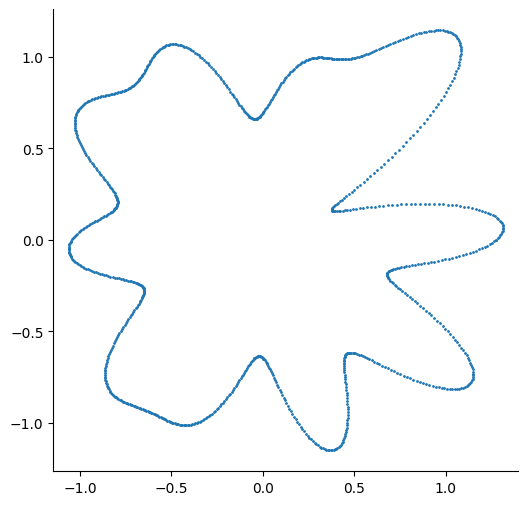

In [37]:


amplitudes = 0.4 * np.random.rand(num_modes) - 0.2
phases = 2 * np.pi * np.random.rand(num_modes)
angles = np.linspace(0, 2*np.pi, num_points)
radii = random_radius_function(angles, amplitudes, phases)
radius_fun = lambda angles: random_radius_function(angles, amplitudes, phases)


x = radii * np.cos(angles)
y = radii * np.sin(angles)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=1)
plt.axis('equal')
plt.show()

In [39]:
import sys
sys.path.append('/Users/binxuwang/Github/DiffusionMemorization')
from os.path import join
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss
from tqdm import trange, tqdm #.notebook
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from core.utils.plot_utils import saveallforms
from core.gaussian_mixture_lib import GaussianMixture, GaussianMixture_torch
from sklearn.model_selection import train_test_split

### Diffusion utils

In [149]:
def marginal_prob_std(t, sigma):
  """Note that this std -> 0, when t->0
  So it's not numerically stable to sample t=0 in the dataset
  Note an earlier version missed the sqrt...
  """
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) ) # sqrt fixed Jun.19


def denoise_loss_fn(model, x, marginal_prob_std_f, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std_f(random_t,)
  perturbed_x = x + z * std[:, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss


def train_score_td(X_train_tsr, score_model_td=None,
                   sigma=25,
                   lr=0.005,
                   nepochs=750,
                   eps=1E-3,
                   batch_size=None,
                   device="cpu"):
    ndim = X_train_tsr.shape[1]
    if score_model_td is None:
        score_model_td = ScoreModel_Time(sigma=sigma, ndim=ndim)
    score_model_td.to(device)
    X_train_tsr = X_train_tsr.to(device)
    marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
    optim = Adam(score_model_td.parameters(), lr=lr)
    pbar = trange(nepochs)
    score_model_td.train()
    loss_traj = []
    for ep in pbar:
        if batch_size is None:
            loss = denoise_loss_fn(score_model_td, X_train_tsr, marginal_prob_std_f, eps=eps)
        else:
            idx = torch.randint(0, X_train_tsr.shape[0], (batch_size,))
            loss = denoise_loss_fn(score_model_td, X_train_tsr[idx], marginal_prob_std_f, eps=eps)

        optim.zero_grad()
        loss.backward()
        optim.step()
        pbar.set_description(f"step {ep} loss {loss.item():.3f}")
        if ep == 0:
            print(f"step {ep} loss {loss.item():.3f}")
        loss_traj.append(loss.item())
    return score_model_td, loss_traj



def reverse_diffusion_time_dep(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False, device="cpu"):
  """
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  lambdaT = (sigma**2 - 1) / (2 * np.log(sigma))
  xT = np.sqrt(lambdaT) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, sigma)
      score_xt = gmm_t.score(x_traj_rev[:,:,i-1])
    else:
      with torch.no_grad():
        score_xt = score_model_td(torch.tensor(x_traj_rev[:,:,i-1]).float(), tvec).numpy()
    # simple Euler-Maryama integration of SGD
    x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)
  return x_traj_rev


def reverse_diffusion_time_dep_torch(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False, device="cpu"):
  """More efficient version that run solely on device
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  lambdaT = (sigma**2 - 1) / (2 * math.log(sigma))
  xT = math.sqrt(lambdaT) * torch.randn(sampN, ndim, device=device)
  x_traj_rev = torch.zeros((sampN, ndim, nsteps), device="cpu")
  x_traj_rev[:, :, 0] = xT.cpu()
  dt = 1 / nsteps
  x_next = xT
  for i in range(1, nsteps):
      t = 1 - i * dt
      tvec = torch.ones((sampN,), device=device) * t
      eps_z = torch.randn_like(xT)
      with torch.no_grad():
        score_xt = score_model_td(x_next, tvec)
      # if exact:
      #     gmm_t = diffuse_gmm(score_model_td, t, sigma, device)
      #     score_xt = gmm_t.score(x_traj_rev[:, :, i-1])
      # else:
      x_next = x_next + eps_z * (sigma ** t) * math.sqrt(dt) + score_xt * dt * sigma**(2*t)
      x_traj_rev[:, :, i] = x_next.cpu()

  return x_traj_rev


def reverse_diffusion_deterministic_torch(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False, device="cpu"):
  """More efficient version that run solely on device
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  lambdaT = (sigma**2 - 1) / (2 * math.log(sigma))
  xT = math.sqrt(lambdaT) * torch.randn(sampN, ndim, device=device)
  x_traj_rev = torch.zeros((sampN, ndim, nsteps), device="cpu")
  x_traj_rev[:, :, 0] = xT.cpu()
  dt = 1 / nsteps
  x_next = xT
  for i in range(1, nsteps):
      t = 1 - i * dt
      tvec = torch.ones((sampN,), device=device) * t
      # eps_z = torch.randn_like(xT)
      with torch.no_grad():
        score_xt = score_model_td(x_next, tvec)
      # if exact:
      #     gmm_t = diffuse_gmm(score_model_td, t, sigma, device)
      #     score_xt = gmm_t.score(x_traj_rev[:, :, i-1])
      # else:
      # x_next = x_next + eps_z * (sigma ** t) * math.sqrt(dt) + score_xt * dt * sigma**(2*t)
      # sigma_t = math.sqrt((sigma**(2*t) - 1) / (2 * math.log(sigma)))
      x_next = x_next + score_xt * dt * sigma**(2*t) / 2
      x_traj_rev[:, :, i] = x_next.cpu()

  return x_traj_rev


def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

### Pedestrian MLP Score Network

In [25]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [86]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps.
  Basically it multiplexes a scalar `t` into a vector of `sin(2 pi k t)` and `cos(2 pi k t)` features.
  """
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, t):
    t_proj = t.view(-1, 1) * self.W[None, :] * 2 * math.pi
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)


class ScoreModel_Time(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ndim=2, nlayers=5, nhidden=50, time_embed_dim=10,
               act_fun=nn.Tanh):
    super().__init__()
    self.embed = GaussianFourierProjection(time_embed_dim, scale=1)
    layers = []
    layers.extend([nn.Linear(time_embed_dim + ndim, nhidden),
                   act_fun()])
    for _ in range(nlayers-2):
        layers.extend([nn.Linear(nhidden, nhidden),
                         act_fun()])
    layers.extend([nn.Linear(nhidden, ndim)])
    self.net = nn.Sequential(*layers)
    self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

  def forward(self, x, t):
    std_vec = self.marginal_prob_std_f(t)[:, None,]
    t_embed = self.embed(t)
    pred = self.net(torch.cat((x / (1 + std_vec ** 2).sqrt(),
                               t_embed), dim=1))
    # this additional steps provides an inductive bias.
    # the neural network output on the same scale,
    pred = pred / std_vec
    return pred


class ScoreModel_Time_edm(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ndim=2, nlayers=5, nhidden=50, time_embed_dim=10,
               act_fun=nn.Tanh):
    super().__init__()
    self.embed = GaussianFourierProjection(time_embed_dim, scale=1)
    layers = []
    layers.extend([nn.Linear(time_embed_dim + ndim, nhidden), act_fun()])
    for _ in range(nlayers - 2):
        layers.extend([nn.Linear(nhidden, nhidden), act_fun()])
    layers.extend([nn.Linear(nhidden, ndim)])
    self.net = nn.Sequential(*layers)
    self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

  def forward(self, x, t):
    std_vec = self.marginal_prob_std_f(t)[:, None,]
    ln_std_vec = torch.log(std_vec) / 4
    t_embed = self.embed(ln_std_vec)
    pred = self.net(torch.cat((x / (1 + std_vec ** 2).sqrt(),
                               t_embed), dim=1))
    # this additional steps provides an inductive bias.
    # the neural network output on the same scale,
    pred = pred / std_vec - x / (1 + std_vec ** 2)
    return pred


class MLPResBlock(nn.Module):
    def __init__(self, in_features, out_features=None, activation=nn.ReLU):
        super(MLPResBlock, self).__init__()
        out_features = out_features or in_features
        self.fc = nn.Linear(in_features, out_features)
        self.activation = activation()
        self.norm = nn.LayerNorm(out_features)
        # Ensure the input can be added to the output
        self.shortcut = nn.Identity() if in_features == out_features \
                                    else nn.Linear(in_features, out_features)

    def forward(self, x):
        # Save the input for residual connection
        identity = self.shortcut(x)
        # Linear layer followed by activation
        out = self.norm(x)
        out = self.fc(out)
        out = self.activation(out)
        # Residual connection
        out = out + identity
        return out
      


class ScoreModel_Time_resnet_edm(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ndim=2, nlayers=5, nhidden=50, time_embed_dim=10,
               act_fun=nn.Tanh):
    super().__init__()
    self.embed = GaussianFourierProjection(time_embed_dim, scale=1)
    layers = []
    layers.extend([nn.Linear(time_embed_dim + ndim, nhidden), act_fun()])
    for _ in range(nlayers - 2):
        layers.extend([MLPResBlock(nhidden, activation=act_fun)])
    layers.extend([nn.Linear(nhidden, ndim)])
    self.net = nn.Sequential(*layers)
    self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

  def forward(self, x, t):
    std_vec = self.marginal_prob_std_f(t)[:, None,]
    ln_std_vec = torch.log(std_vec) / 4
    t_embed = self.embed(ln_std_vec)
    pred = self.net(torch.cat((x / (1 + std_vec ** 2).sqrt(),
                               t_embed), dim=1))
    # this additional steps provides an inductive bias.
    # the neural network output on the same scale,
    pred = pred / std_vec - x / (1 + std_vec ** 2)
    return pred

In [85]:
tmp_model = ScoreModel_Time_resnet_edm(10)
out = tmp_model(torch.randn(5, 2), torch.ones(5))
out.sum().backward()

In [64]:
pnts, radius_fun, amplitudes, phases = create_random_star_shape(10000, 10)
pnts_tsr = 3 * torch.tensor(pnts).float()
Xtrain, Xtest = train_test_split(pnts_tsr, test_size=0.01, random_state=42)

sigma5 mlp depth 5 layer width 512 hidden unit
batch size 1024
dataset star_shape_rnd
parameter count 856066


step 9 loss 1.674:   0%|          | 5/2500 [00:00<00:51, 48.36it/s]

step 0 loss 2.342


step 2499 loss 1.121: 100%|██████████| 2500/2500 [00:39<00:00, 62.92it/s]


{'loss_init': 2.3421528339385986, 'loss_end': 1.1211258172988892, 'loss_end_10': 1.2044027686119079, 'loss_end_100': 1.1934529614448548, 'mlp_detail': 'sigma5 mlp depth 5 layer width 512 hidden unit', 'batch_size': 1024, 'epochs': 2500, 'dataset': 'star_shape_rnd', 'sigma': 5, 'depth': 5, 'width': 512, 'time_embed_dim': 128}


/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_10051/4192081307.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


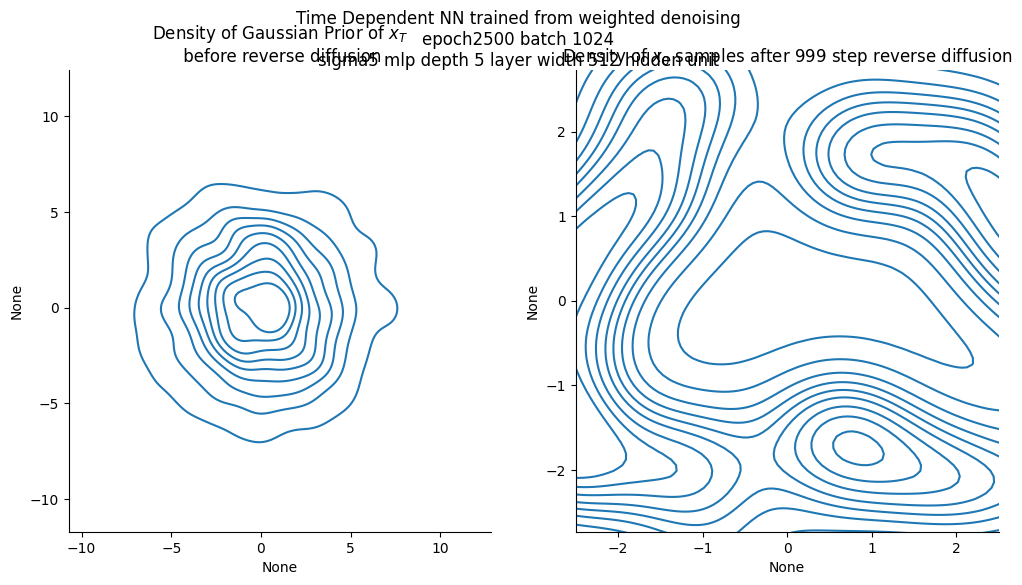

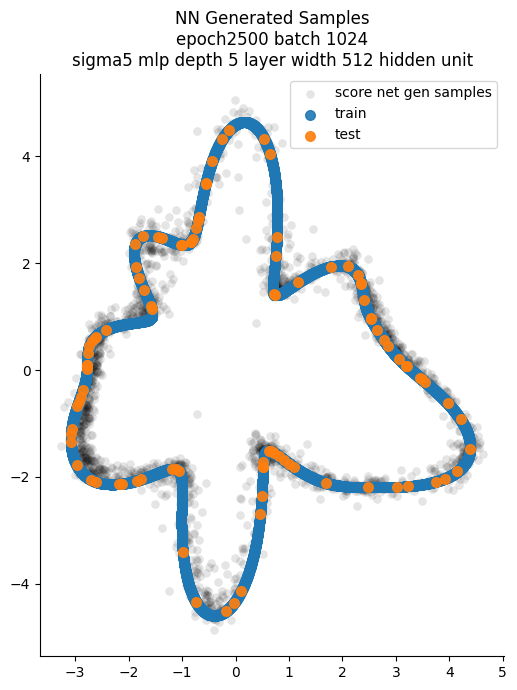

In [66]:
pnts, radius_fun, amplitudes, phases = create_random_star_shape(10000, 10)
pnts_tsr = 3 * torch.tensor(pnts).float()
Xtrain, Xtest = train_test_split(pnts_tsr, test_size=0.01, random_state=42)
epochs = 2500
sigma_max = 10
mlp_depth = 5
mlp_width = 512
time_embed_dim = 128
model_cfg_str = f"sigma{sigma_max} mlp depth {mlp_depth} layer width {mlp_width} hidden unit"
cfg_fn_str = f"depth{mlp_depth}_width{mlp_width}"
dataset_str = "star_shape_rnd"
batch_size = 1024

torch.manual_seed(42)
score_model_td = ScoreModel_Time_edm(sigma=sigma_max, ndim=2, 
                nlayers=mlp_depth, nhidden=mlp_width, time_embed_dim=time_embed_dim,)
print(model_cfg_str)
print(f"batch size {batch_size}")
print(f"dataset {dataset_str}")
print("parameter count", sum(p.numel() for p in score_model_td.parameters() if p.requires_grad))

score_model_td, loss_traj = train_score_td(Xtrain, score_model_td=score_model_td,
                sigma=sigma_max, lr=0.001, nepochs=epochs, batch_size=batch_size, device="cpu")
stats = {"loss_init": loss_traj[0], "loss_end" : loss_traj[-1], 
        "loss_end_10": np.mean(loss_traj[-10:]), "loss_end_100": np.mean(loss_traj[-100:]),
        "mlp_detail": model_cfg_str, 
        "batch_size": batch_size, "epochs": epochs,
        "dataset": dataset_str, "sigma": sigma_max,
        "depth": mlp_depth, "width": mlp_width, "time_embed_dim": time_embed_dim}
# stats_col.append(stats)
print(stats)
x_traj_denoise = reverse_diffusion_time_dep_torch(score_model_td, 
    sampN=2000, sigma=sigma_max, nsteps=1000, ndim=2, exact=False, device="cpu")
figh = visualize_diffusion_distr(x_traj_denoise,
                    explabel=f"Time Dependent NN trained from weighted denoising\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
# figh.axes[1].set_xlim([-2.5, 2.5])
# figh.axes[1].set_ylim([-2.5, 2.5])
# saveallforms(figdir, f"{dataset_str}_NN_contour_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
figh.show()

plt.figure(figsize=(7, 7))
plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], alpha=0.1, lw=0.1, color="k", label="score net gen samples")
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
# plt.xlim(-2.8, 2.8)
# plt.ylim(-2.8, 2.8)
plt.title(f"NN Generated Samples\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

sigma10 mlp depth 5 layer width 512 hidden unit
batch size 1024
dataset star_shape_rnd
parameter count 859138


  0%|          | 0/2500 [00:00<?, ?it/s]

step 9 loss 3.243:   0%|          | 5/2500 [00:00<00:56, 43.99it/s]

step 0 loss 2.322


step 2499 loss 1.031: 100%|██████████| 2500/2500 [00:36<00:00, 67.80it/s]


{'loss_init': 2.321895122528076, 'loss_end': 1.030819058418274, 'loss_end_10': 1.074194312095642, 'loss_end_100': 1.0792623645067214, 'mlp_detail': 'sigma10 mlp depth 5 layer width 512 hidden unit', 'batch_size': 1024, 'epochs': 2500, 'dataset': 'star_shape_rnd', 'sigma': 10, 'depth': 5, 'width': 512, 'time_embed_dim': 128}


/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_10051/3204790241.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


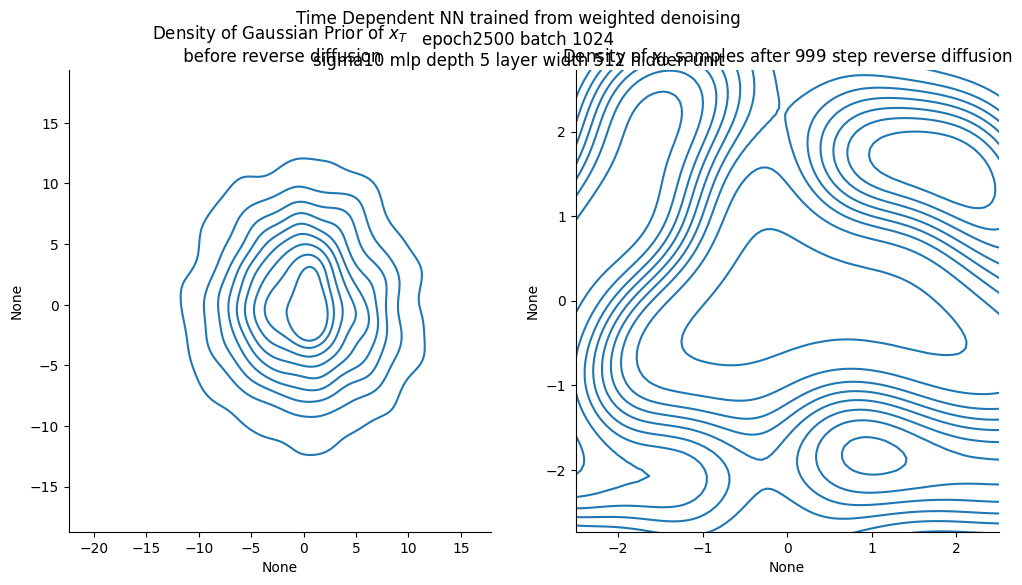

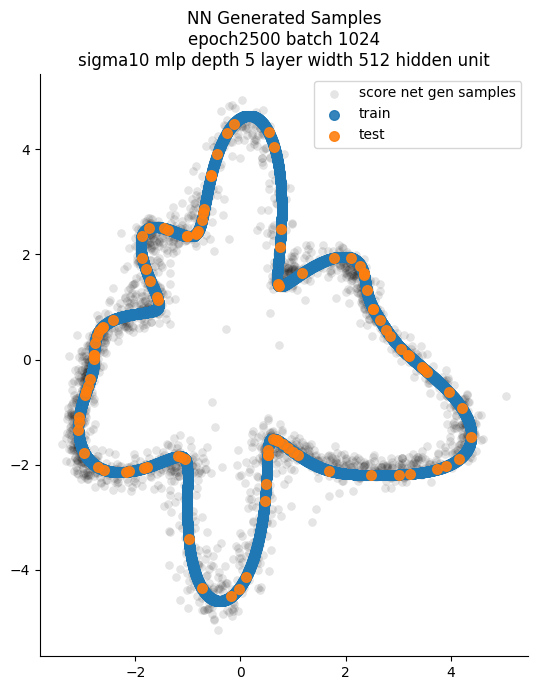

In [88]:
epochs = 2500
sigma_max = 10
mlp_depth = 5
mlp_width = 512
time_embed_dim = 128
model_cfg_str = f"sigma{sigma_max} mlp depth {mlp_depth} layer width {mlp_width} hidden unit"
cfg_fn_str = f"resMLP depth{mlp_depth}_width{mlp_width}"
dataset_str = "star_shape_rnd"
batch_size = 1024

torch.manual_seed(42)
score_model_td = ScoreModel_Time_resnet_edm(sigma=sigma_max, ndim=2, 
                nlayers=mlp_depth, nhidden=mlp_width, time_embed_dim=time_embed_dim,)
print(model_cfg_str)
print(f"batch size {batch_size}")
print(f"dataset {dataset_str}")
print("parameter count", sum(p.numel() for p in score_model_td.parameters() if p.requires_grad))

score_model_td, loss_traj = train_score_td(Xtrain, score_model_td=score_model_td,
                sigma=sigma_max, lr=0.001, nepochs=epochs, batch_size=batch_size, device="mps")
stats = {"loss_init": loss_traj[0], "loss_end" : loss_traj[-1], 
        "loss_end_10": np.mean(loss_traj[-10:]), "loss_end_100": np.mean(loss_traj[-100:]),
        "mlp_detail": model_cfg_str, 
        "batch_size": batch_size, "epochs": epochs,
        "dataset": dataset_str, "sigma": sigma_max,
        "depth": mlp_depth, "width": mlp_width, "time_embed_dim": time_embed_dim}
# stats_col.append(stats)
print(stats)
x_traj_denoise = reverse_diffusion_time_dep_torch(score_model_td, 
    sampN=2000, sigma=sigma_max, nsteps=1000, ndim=2, exact=False, device="mps")
figh = visualize_diffusion_distr(x_traj_denoise,
                    explabel=f"Time Dependent NN trained from weighted denoising\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
figh.axes[1].set_xlim([-2.5, 2.5])
figh.axes[1].set_ylim([-2.5, 2.5])
# saveallforms(figdir, f"{dataset_str}_NN_contour_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
figh.show()

plt.figure(figsize=(7, 7))
plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], alpha=0.1, lw=0.1, color="k", label="score net gen samples")
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
# plt.xlim(-2.8, 2.8)
# plt.ylim(-2.8, 2.8)
plt.title(f"NN Generated Samples\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

### Adapted UNet block architecture for MLP structure

In [128]:
import torch
import torch.nn.functional as F
from torch.nn import GroupNorm, Linear

class UNetMLPBlock(torch.nn.Module):
    def __init__(self,
        in_features, out_features, emb_features, dropout=0, skip_scale=1, eps=1e-5,
        adaptive_scale=True, init=dict(), init_zero=dict(),
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.emb_features = emb_features
        self.dropout = dropout
        self.skip_scale = skip_scale
        self.adaptive_scale = adaptive_scale

        self.norm0 = nn.LayerNorm(in_features, eps=eps) #GroupNorm(num_channels=in_features, eps=eps)
        self.fc0 = Linear(in_features=in_features, out_features=out_features, **init)
        self.affine = Linear(in_features=emb_features, out_features=out_features*(2 if adaptive_scale else 1), **init)
        self.norm1 = nn.LayerNorm(out_features, eps=eps) #GroupNorm(num_channels=out_features, eps=eps)
        self.fc1 = Linear(in_features=out_features, out_features=out_features, **init_zero)

        self.skip = None
        if out_features != in_features:
            self.skip = Linear(in_features=in_features, out_features=out_features, **init)

    def forward(self, x, emb):
        orig = x
        x = self.fc0(F.silu(self.norm0(x)))
        # print(x.shape)
        # print(emb.shape)
        params = self.affine(emb).to(x.dtype) # .unsqueeze(1)
        # print(params.shape)
        if self.adaptive_scale:
            scale, shift = params.chunk(chunks=2, dim=1)
            x = F.silu(torch.addcmul(shift, self.norm1(x), scale + 1))
        else:
            x = F.silu(self.norm1(x.add_(params)))

        x = self.fc1(F.dropout(x, p=self.dropout, training=self.training))
        x = x.add_(self.skip(orig) if self.skip is not None else orig)
        x = x * self.skip_scale
        # print(x.shape)

        return x

In [129]:
class ScoreModel_Time_UNetlike_edm(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ndim=2, nlayers=5, nhidden=50, time_embed_dim=10,
               act_fun=nn.Tanh):
    super().__init__()
    self.embed = GaussianFourierProjection(time_embed_dim, scale=1)
    layers = nn.ModuleList()
    layers.append(UNetMLPBlock(ndim, nhidden, time_embed_dim))
    for _ in range(nlayers-2):
        layers.append(UNetMLPBlock(nhidden, nhidden, time_embed_dim))
    # layers.extend([nn.Linear(time_embed_dim + ndim, nhidden), act_fun()])
    # for _ in range(nlayers - 2):
    #     layers.extend([MLPResBlock(nhidden, activation=act_fun)])
    layers.append(nn.Linear(nhidden, ndim))
    self.net = layers
    self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

  def forward(self, x, t):
    std_vec = self.marginal_prob_std_f(t)[:, None,]
    ln_std_vec = torch.log(std_vec) / 4
    t_embed = self.embed(ln_std_vec)
    orig = nn.Identity()(x)
    x = x / (1 + std_vec ** 2).sqrt()
    for layer in self.net[:-1]:
        x = layer(x, t_embed)
    pred = self.net[-1](x)
    # pred = self.net(torch.cat((x / (1 + std_vec ** 2).sqrt(),
    #                            t_embed), dim=1))
    # this additional steps provides an inductive bias.
    # the neural network output on the same scale,
    # print(pred.shape)
    # print(std_vec.shape)
    pred = pred / std_vec - orig / (1 + std_vec ** 2)
    return pred

In [131]:
tmp = ScoreModel_Time_UNetlike_edm(10, nhidden=50, time_embed_dim=64)
tmp(torch.randn(5, 2), torch.ones(5))

tensor([[ 0.0049, -0.2391],
        [-0.0240, -0.1658],
        [-0.0459, -0.2236],
        [-0.0230, -0.1752],
        [ 0.0489, -0.1902]], grad_fn=<SubBackward0>)

sigma10 mlp depth 5 layer width 512 hidden unit
batch size 1024
dataset star_shape_rnd
parameter count 2116102


step 5 loss 10.852:   0%|          | 4/2500 [00:01<08:38,  4.82it/s] 

step 0 loss 2.268


step 2499 loss 1.080: 100%|██████████| 2500/2500 [01:19<00:00, 31.59it/s]


{'loss_init': 2.2677931785583496, 'loss_end': 1.0801377296447754, 'loss_end_10': 1.1268174409866334, 'loss_end_100': 1.107957011461258, 'mlp_detail': 'sigma10 mlp depth 5 layer width 512 hidden unit', 'batch_size': 1024, 'epochs': 2500, 'dataset': 'star_shape_rnd', 'sigma': 10, 'depth': 5, 'width': 512, 'time_embed_dim': 64}


/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_10051/2065874236.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


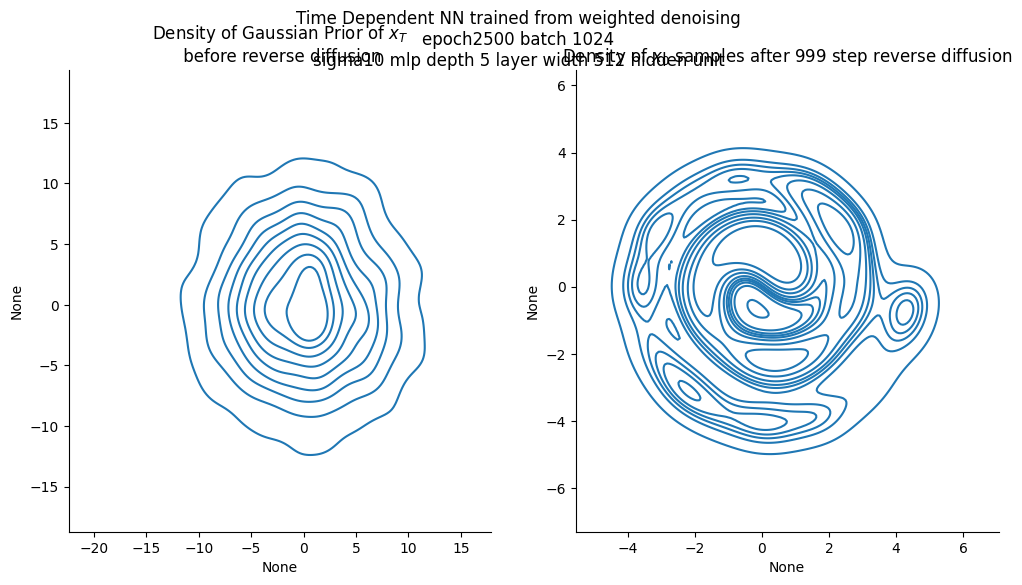

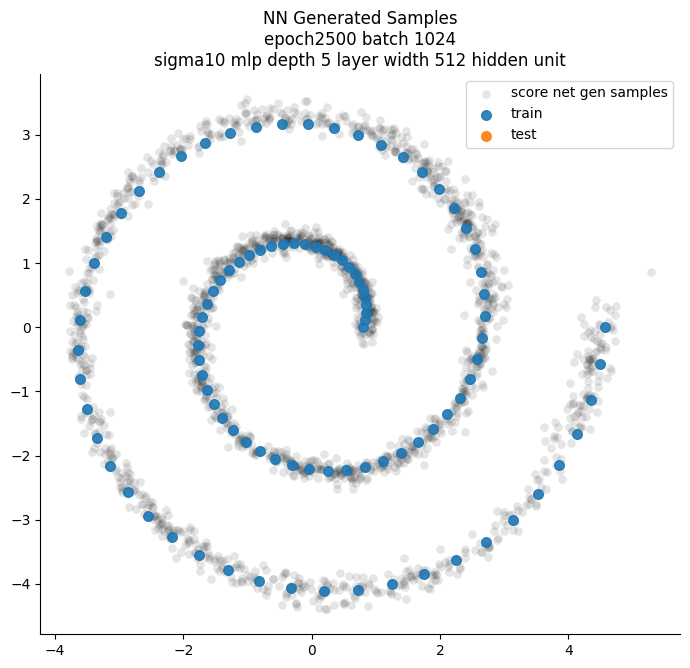

In [132]:

train_pnts = 100
ring_X = 2*generate_spiral_samples_torch(train_pnts, a=0.4, b=0.15)
# train test split
Xtrain, Xtest = ring_X, torch.empty(0, 2)

sigma_max = 10
mlp_depth = 5
mlp_width = 512
time_embed_dim = 64
epochs = 2500
batch_size = 1024
model_cfg_str = f"sigma{sigma_max} mlp depth {mlp_depth} layer width {mlp_width} hidden unit"
cfg_fn_str = f"depth{mlp_depth}_width{mlp_width}"
dataset_str = "star_shape_rnd"

torch.manual_seed(42)

# ScoreModel_Time_edm
score_model_td = ScoreModel_Time_UNetlike_edm(sigma=sigma_max, ndim=2, 
                nlayers=mlp_depth, nhidden=mlp_width, time_embed_dim=time_embed_dim,)
print(model_cfg_str)
print(f"batch size {batch_size}")
print(f"dataset {dataset_str}")
print("parameter count", sum(p.numel() for p in score_model_td.parameters() if p.requires_grad))

score_model_td, loss_traj = train_score_td(Xtrain, score_model_td=score_model_td,
                sigma=sigma_max, lr=0.002, nepochs=epochs, batch_size=batch_size, device="mps")
stats = {"loss_init": loss_traj[0], "loss_end" : loss_traj[-1], 
        "loss_end_10": np.mean(loss_traj[-10:]), "loss_end_100": np.mean(loss_traj[-100:]),
        "mlp_detail": model_cfg_str, 
        "batch_size": batch_size, "epochs": epochs,
        "dataset": dataset_str, "sigma": sigma_max,
        "depth": mlp_depth, "width": mlp_width, "time_embed_dim": time_embed_dim}
# stats_col.append(stats)
print(stats)
x_traj_denoise = reverse_diffusion_time_dep_torch(score_model_td, 
    sampN=2000, sigma=sigma_max, nsteps=1000, ndim=2, exact=False, device="mps")
figh = visualize_diffusion_distr(x_traj_denoise,
                    explabel=f"Time Dependent NN trained from weighted denoising\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
# figh.axes[1].set_xlim([-2.5, 2.5])
# figh.axes[1].set_ylim([-2.5, 2.5])
# saveallforms(figdir, f"{dataset_str}_NN_contour_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
figh.show()

plt.figure(figsize=(7, 7))
plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], alpha=0.1, lw=0.1, color="k", label="score net gen samples")
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
# plt.xlim(-2.8, 2.8)
# plt.ylim(-2.8, 2.8)
plt.title(f"NN Generated Samples\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

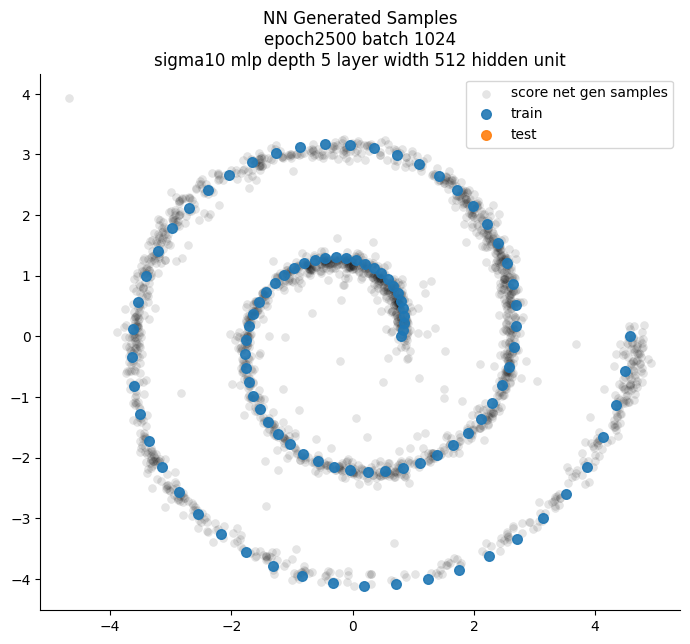

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], alpha=0.1, lw=0.1, color="k", label="score net gen samples")
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
# plt.xlim(-2.8, 2.8)
# plt.ylim(-2.8, 2.8)
plt.title(f"NN Generated Samples\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

sigma10 mlp depth 5 layer width 512 hidden unit
batch size 1024
dataset star_shape_rnd
parameter count 2378246


step 4 loss 14.429:   0%|          | 3/2500 [00:00<03:41, 11.25it/s] 

step 0 loss 2.470


step 2499 loss 1.043: 100%|██████████| 2500/2500 [01:19<00:00, 31.60it/s]


{'loss_init': 2.4700255393981934, 'loss_end': 1.0427796840667725, 'loss_end_10': 1.0611148476600647, 'loss_end_100': 1.0670089739561082, 'mlp_detail': 'sigma10 mlp depth 5 layer width 512 hidden unit', 'batch_size': 1024, 'epochs': 2500, 'dataset': 'star_shape_rnd', 'sigma': 10, 'depth': 5, 'width': 512, 'time_embed_dim': 128}


/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_10051/3101410165.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


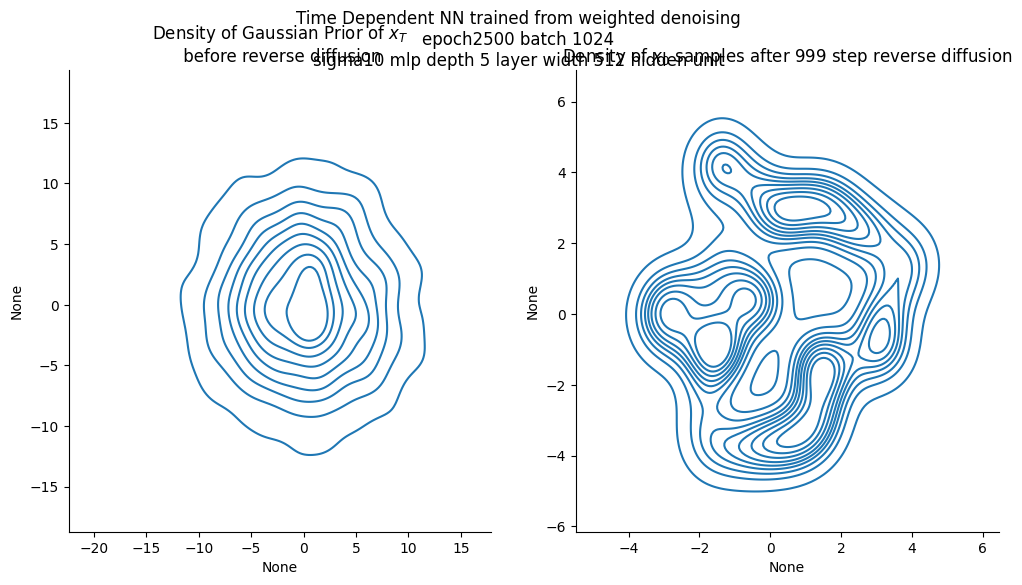

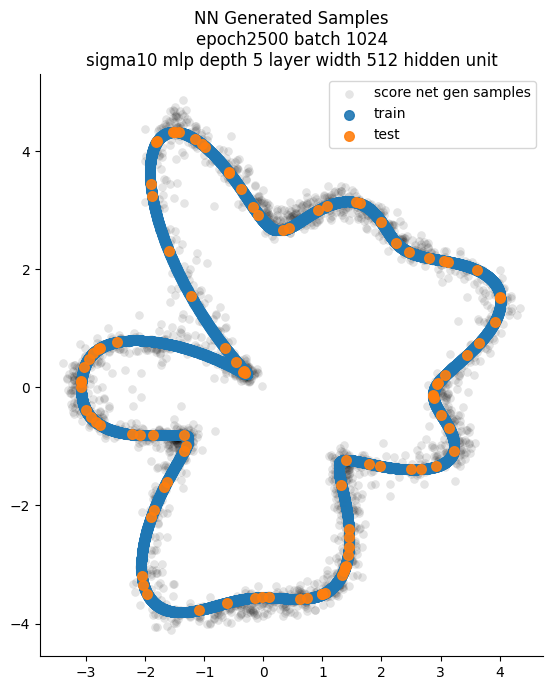

In [134]:
pnts, radius_fun, amplitudes, phases = create_random_star_shape(10000, 10)
pnts_tsr = 3 * torch.tensor(pnts).float()
Xtrain, Xtest = train_test_split(pnts_tsr, test_size=0.01, random_state=42)
epochs = 2500
sigma_max = 10
mlp_depth = 5
mlp_width = 512
time_embed_dim = 128
model_cfg_str = f"sigma{sigma_max} mlp depth {mlp_depth} layer width {mlp_width} hidden unit"
cfg_fn_str = f"depth{mlp_depth}_width{mlp_width}"
dataset_str = "star_shape_rnd"
batch_size = 1024

torch.manual_seed(42)
score_model_td = ScoreModel_Time_UNetlike_edm(sigma=sigma_max, ndim=2, 
                nlayers=mlp_depth, nhidden=mlp_width, time_embed_dim=time_embed_dim,)
print(model_cfg_str)
print(f"batch size {batch_size}")
print(f"dataset {dataset_str}")
print("parameter count", sum(p.numel() for p in score_model_td.parameters() if p.requires_grad))

score_model_td, loss_traj = train_score_td(Xtrain, score_model_td=score_model_td,
                sigma=sigma_max, lr=0.001, nepochs=epochs, batch_size=batch_size, device="mps")
stats = {"loss_init": loss_traj[0], "loss_end" : loss_traj[-1], 
        "loss_end_10": np.mean(loss_traj[-10:]), "loss_end_100": np.mean(loss_traj[-100:]),
        "mlp_detail": model_cfg_str, 
        "batch_size": batch_size, "epochs": epochs,
        "dataset": dataset_str, "sigma": sigma_max,
        "depth": mlp_depth, "width": mlp_width, "time_embed_dim": time_embed_dim}
# stats_col.append(stats)
print(stats)
x_traj_denoise = reverse_diffusion_time_dep_torch(score_model_td, 
    sampN=2000, sigma=sigma_max, nsteps=1000, ndim=2, exact=False, device="mps")
figh = visualize_diffusion_distr(x_traj_denoise,
                    explabel=f"Time Dependent NN trained from weighted denoising\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
# figh.axes[1].set_xlim([-2.5, 2.5])
# figh.axes[1].set_ylim([-2.5, 2.5])
# saveallforms(figdir, f"{dataset_str}_NN_contour_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
figh.show()

plt.figure(figsize=(7, 7))
plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], alpha=0.1, lw=0.1, color="k", label="score net gen samples")
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
# plt.xlim(-2.8, 2.8)
# plt.ylim(-2.8, 2.8)
plt.title(f"NN Generated Samples\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

### Test various sampler

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_10051/39800502.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


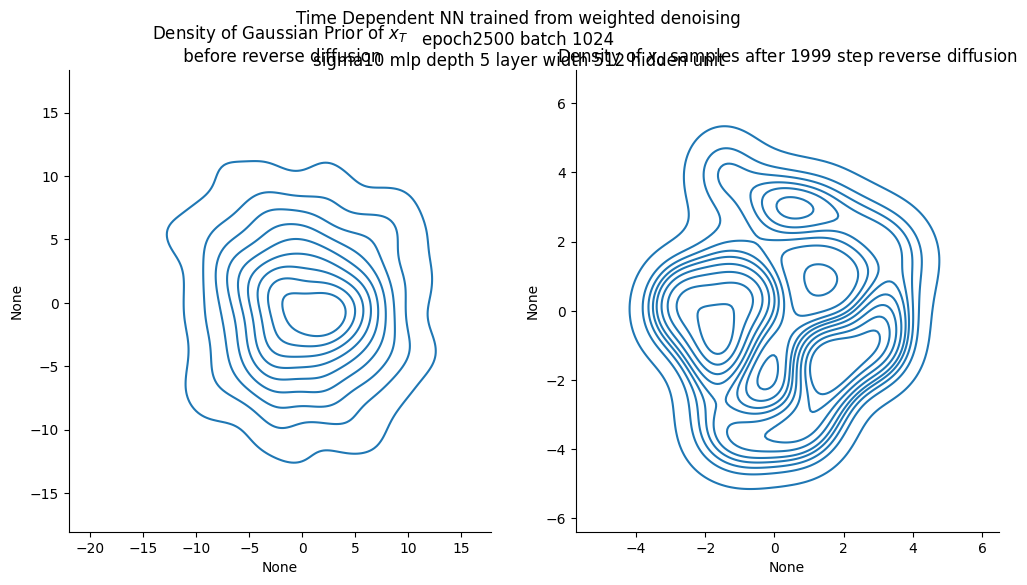

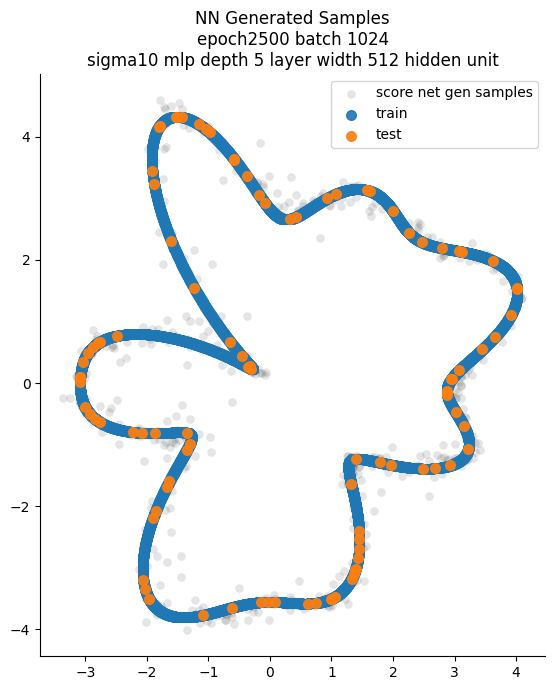

In [151]:
x_traj_denoise = reverse_diffusion_deterministic_torch(score_model_td, 
    sampN=500, sigma=sigma_max, nsteps=2000, ndim=2, exact=False, device="mps")
# x_traj_denoise = reverse_diffusion_time_dep_torch(score_model_td, 
#     sampN=2000, sigma=sigma_max, nsteps=1000, ndim=2, exact=False, device="mps")
figh = visualize_diffusion_distr(x_traj_denoise,
                    explabel=f"Time Dependent NN trained from weighted denoising\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
# saveallforms(figdir, f"{dataset_str}_NN_contour_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
figh.show()

plt.figure(figsize=(7, 7))
plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], alpha=0.1, lw=0.1, color="k", label="score net gen samples")
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
plt.title(f"NN Generated Samples\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

In [161]:
model_cfg_str = "MLP-UNet sigma10 mlp depth 5 layer width 512 hidden unit"

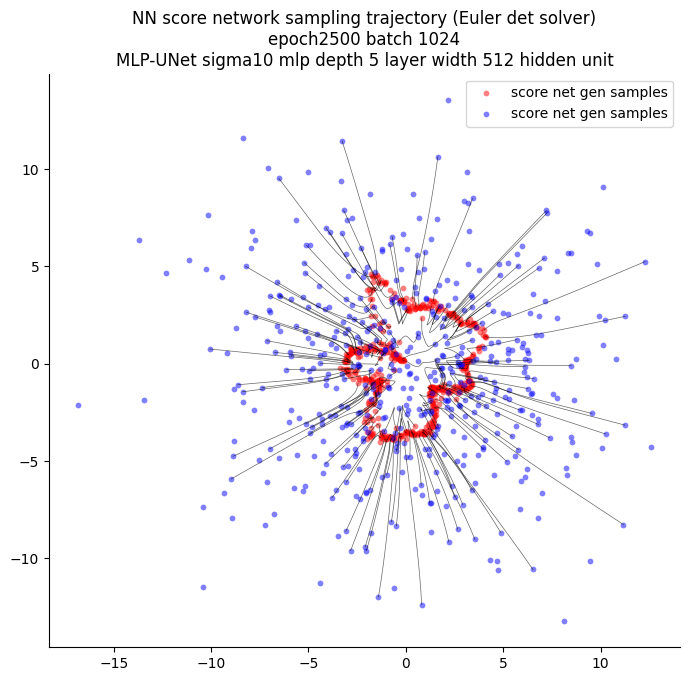

In [163]:
plt.figure(figsize=(7, 7))
plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], s=16, alpha=0.5, lw=0.1, color="red", label="score net gen samples", marker="o")
plt.scatter(x_traj_denoise[:, 0, 0], x_traj_denoise[:, 1, 0], s=16, alpha=0.5, lw=0.1, color="blue", label="score net gen samples", marker="o")
plt.plot(x_traj_denoise[::3, 0, :].T, x_traj_denoise[::3, 1, :].T, alpha=0.6, lw=0.5, color="k", )
# plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
# plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
# plt.xlim(-2.8, 2.8)
# plt.ylim(-2.8, 2.8)
plt.title(f"NN score network sampling trajectory (Euler det solver)\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

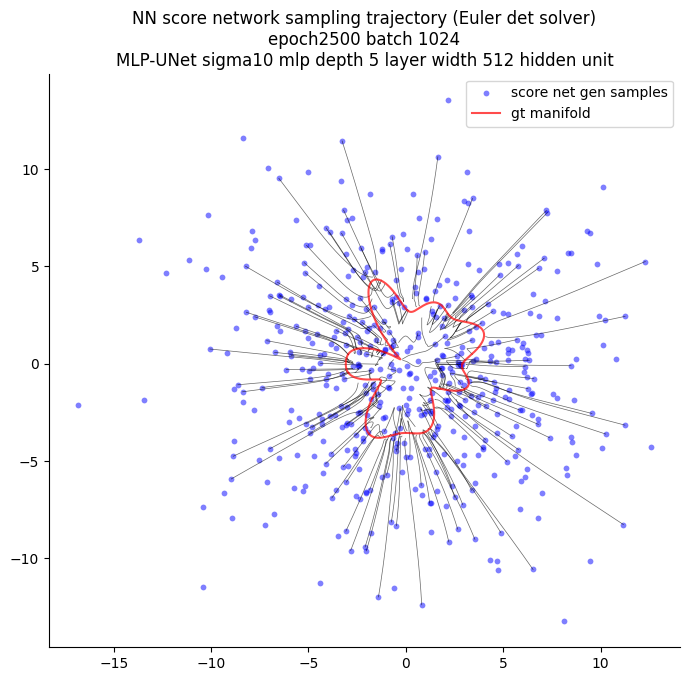

In [172]:
plt.figure(figsize=(7, 7))
# plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], s=16, alpha=0.5, lw=0.1, color="red", label="score net gen samples", marker="o")
plt.scatter(x_traj_denoise[:, 0, 0], x_traj_denoise[:, 1, 0], s=16, alpha=0.5, lw=0.1, color="blue", label="score net gen samples", marker="o")
plt.plot(x_traj_denoise[::3, 0, :].T, x_traj_denoise[::3, 1, :].T, alpha=0.6, lw=0.5, color="k", )
# plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
plt.plot(pnts_tsr[:, 0], pnts_tsr[:, 1], color="red", lw=1.5, alpha=0.7, label="gt manifold")
# plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
# plt.xlim(-2.8, 2.8)
# plt.ylim(-2.8, 2.8)
plt.title(f"NN score network sampling trajectory (Euler det solver)\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

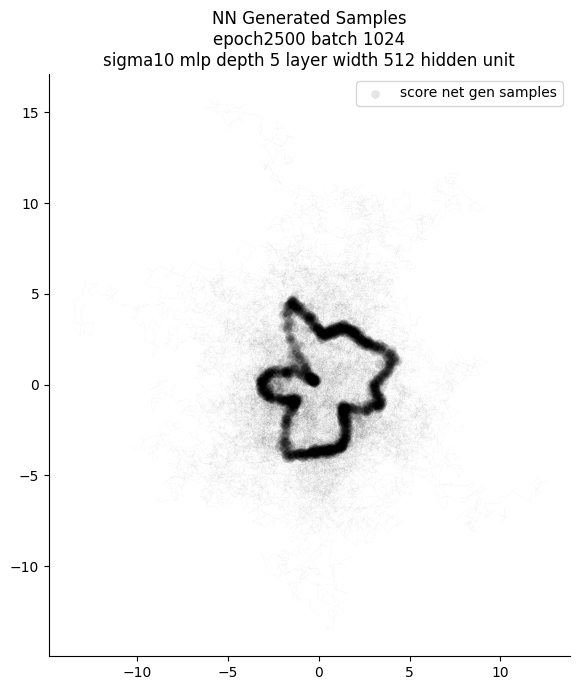

In [137]:
plt.figure(figsize=(7, 7))
plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], alpha=0.1, lw=0.1, color="k", label="score net gen samples")
plt.plot(x_traj_denoise[::20, 0, :].T, x_traj_denoise[::20, 1, :].T, alpha=0.1, lw=0.1, color="k", )
# plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=48, alpha=0.9, label="train", marker="o")
# plt.scatter(Xtest[:, 0], Xtest[:, 1], s=48, alpha=0.9, label="test", marker="o")
plt.axis("image")
# plt.xlim(-2.8, 2.8)
# plt.ylim(-2.8, 2.8)
plt.title(f"NN Generated Samples\nepoch{epochs} batch {batch_size}\n{model_cfg_str}")
plt.legend()
plt.tight_layout()
# saveallforms(figdir, f"{dataset_str}_NN_samples_train_{cfg_fn_str}_batch{batch_size}_ep{epochs:04d}_sde")
plt.show()

In [53]:
def generate_spiral_samples_torch(n_points, a=1, b=0.2):
    """Generate points along a spiral using PyTorch.
    Parameters:
    - n_points (int): Number of points to generate.
    - a, b (float): Parameters that define the spiral shape.
    Returns:
    - torch.Tensor: Batch of vectors representing points on the spiral.
    """
    theta = torch.linspace(0, 4 * np.pi, n_points)  # angle theta
    r = a + b * theta  # radius
    x = r * torch.cos(theta)  # x = r * cos(theta)
    y = r * torch.sin(theta)  # y = r * sin(theta)
    spiral_batch = torch.stack((x, y), dim=1)
    return spiral_batch


def generate_ring_samples_torch(n_points, R=1, ):
    """
    Generate points along a Ring using PyTorch.
    Parameters:
    - n_points (int): Number of points to generate.
    - R: Radius of the ring.
    Returns:
    - torch.Tensor: Batch of vectors representing points on the spiral.
    """
    theta = torch.linspace(0, 2 * np.pi, n_points + 1, )  # angle theta
    theta = theta[:-1]
    x = R * torch.cos(theta)  # x = r * cos(theta)
    y = R * torch.sin(theta)  # y = r * sin(theta)
    spiral_batch = torch.stack((x, y), dim=1)
    return spiral_batch

In [ ]:

def gaussian_mixture_logprob_score_torch(x, mus, Us, Lambdas, weights=None):
    """
    Evaluate log probability and score of a Gaussian mixture model in PyTorch
    :param x: [N batch, N dim]
    :param mus: [N comp, N dim]
    :param Us: [N comp, N dim, N dim]
    :param Lambdas: [N comp, N dim]
    :param weights: [N comp,] or None
    :return:
    """
    ndim = x.shape[-1]
    logdetSigmas = torch.sum(torch.log(Lambdas), dim=-1)  # [N comp,]
    residuals = (x[:, None, :] - mus[None, :, :])  # [N batch, N comp, N dim]
    rot_residuals = torch.einsum("BCD,CDE->BCE", residuals, Us)  # [N batch, N comp, N dim]
    MHdists = torch.sum(rot_residuals ** 2 / Lambdas[None, :, :], dim=-1)  # [N batch, N comp]
    if weights is not None:
        logprobs = (-0.5 * (logdetSigmas[None, :] + MHdists) +
                    torch.log(weights))  # - 0.5 * ndim * torch.log(2 * torch.pi)  # [N batch, N comp]
    else:
        logprobs = -0.5 * (logdetSigmas[None, :] + MHdists)
    participance = F.softmax(logprobs, dim=-1)  # [N batch, N comp]
    compo_score_vecs = torch.einsum("BCD,CED->BCE", - (rot_residuals / Lambdas[None, :, :]),
                                    Us)  # [N batch, N comp, N dim]
    score_vecs = torch.einsum("BC,BCE->BE", participance, compo_score_vecs)  # [N batch, N dim]
    # logsumexp trick
    logprob = torch.logsumexp(logprobs, dim=-1)  # [N batch,]
    logprob -= 0.5 * ndim * math.log(2 * torch.pi)
    return logprob, score_vecs


def gaussian_mixture_score_batch_sigma_torch(x, mus, Us, Lambdas, weights=None):
    """
    Evaluate log probability and score of a Gaussian mixture model in PyTorch
    :param x: [N batch,N dim]
    :param mus: [N comp, N dim]
    :param Us: [N comp, N dim, N dim]
    :param Lambdas: [N batch, N comp, N dim]
    :param weights: [N comp,] or None
    :return:
    """
    if Lambdas.ndim == 2:
        Lambdas = Lambdas[None, :, :]
    ndim = x.shape[-1]
    logdetSigmas = torch.sum(torch.log(Lambdas), dim=-1)  # [N batch, N comp,]
    residuals = (x[:, None, :] - mus[None, :, :])  # [N batch, N comp, N dim]
    rot_residuals = torch.einsum("BCD,CDE->BCE", residuals, Us)  # [N batch, N comp, N dim]
    MHdists = torch.sum(rot_residuals ** 2 / Lambdas, dim=-1)  # [N batch, N comp]
    if weights is not None:
        logprobs = (-0.5 * (logdetSigmas + MHdists) +
                    torch.log(weights))  # - 0.5 * ndim * torch.log(2 * torch.pi)  # [N batch, N comp]
    else:
        logprobs = -0.5 * (logdetSigmas + MHdists)
    participance = F.softmax(logprobs, dim=-1)  # [N batch, N comp]
    compo_score_vecs = torch.einsum("BCD,CED->BCE", - (rot_residuals / Lambdas),
                                    Us)  # [N batch, N comp, N dim]
    score_vecs = torch.einsum("BC,BCE->BE", participance, compo_score_vecs)  # [N batch, N dim]
    return score_vecs

In [ ]:
class GMM_ansatz_net(nn.Module):
    def __init__(self, ndim, n_components, sigma=5.0):
        super().__init__()
        self.ndim = ndim
        self.n_components = n_components
        self.mus = nn.Parameter(torch.randn(n_components, ndim))
        self.Us = nn.Parameter(torch.randn(n_components, ndim, ndim))
        self.logLambdas = nn.Parameter(torch.randn(n_components, ndim))
        self.logweights = nn.Parameter(torch.log(torch.ones(n_components) / n_components))
        self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

    def forward(self, x, t):
        """
        x: (batch, ndim)
        sigma: (batch, )
        """
        sigma = self.marginal_prob_std_f(t)
        return gaussian_mixture_score_batch_sigma_torch(x, self.mus, self.Us,
               self.logLambdas.exp()[None, :, :] + sigma[:, None, None]**2, self.logweights.exp())



In [ ]:
import torch

def score_matching_loss(model, X, sigma):
    noise = torch.randn_like(X)
    X_noised = X + noise * sigma
    denoised = model(X_noised, sigma)
    
    
    
    num_points = x.shape[0]
    x = x.reshape((num_points, 1))
    y = y.reshape((num_points, 1))
    x_diff = x - x.T
    y_diff = y - y.T
    dists = x_diff**2 + y_diff**2
    return np.sum(np.exp(-dists / (2 * sigma**2))) / num_points**2